Data Visualization

In [1]:
import jax
import flax
import optax
from jax import lax, random, numpy as jnp
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax import config
from flax import linen as nn
from scipy.integrate import odeint

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
jax.config.update("jax_enable_x64", True)

In [2]:
!pip install evojax
from evojax.util import get_params_format_fn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.7/269.7 kB 10.2 MB/s eta 0:00:00


In [3]:
#true params
Ka_true = 2.821 # 1/h - not in spreadsheet
Ke_true = 0.693/6.3 # 1/h
V_blood_true = 19 # L
V_gut_true = 1.3612 # L
dosage_true = 100.5348 #mg, just for reference

In [4]:
#initial conditions
A1_init = 73.864090508375 # / V_gut_true # (mg/L) #needs to be decided
A2_init = 0 # (mg/L)

In [5]:
# task array
# Ka_params = jnp.linspace(1., 10., 5)
# Ke_params = jnp.linspace(0.0001, 1., 5)
# V_gut_params = jnp.linspace(0.5, 2.5, 5) #cannot divide by 0, trying to only predict blood for now #V1
# V_blood_params = jnp.linspace(10., 25., 5) #cannot divide by 0, trying to only predict blood for now #V2

# task_params = jnp.stack((Ka_params, Ke_params, V_gut_params, V_blood_params), axis=1)

task_params = np.array([[Ka_true, Ke_true, V_gut_true, V_blood_true]])

n_task = len(task_params)
n_task, task_params

(1, array([[ 2.821 ,  0.11  ,  1.3612, 19.    ]]))

Obtaining Ground Truth

In [6]:
#caffeine equation solution generator
def caffeine(y, t, Ka, Ke, V_gut, V_blood):
    """A1 and A2 terms are not divided by V, they are just divided before being plotted"""
    A1_sys, A2_sys = y
    dydt = [-Ka* (A1_sys), Ka*(A1_sys) - Ke*(A2_sys)]
    return dydt

In [7]:
data_A1, data_A2, data_S = [], [], [] #collect all 6 tasks (different combination of a1 a2) #data S is all zeroes
t = jnp.linspace(0, 24, 201)
t_param = t #copy for calculating ODE
t = np.expand_dims(t, axis=1) #for data_X

data_T = t
for task in task_params:

    y0 = [A1_init * V_gut_true, A2_init * V_blood_true] #must scale A1 and A2 if all resulting A1/A2 values are divided by V

    #get ODE soln for A2
    sol = odeint(caffeine, y0, t_param, args=(Ka_true, Ke_true, V_gut_true, V_blood_true))
    A1_soln = sol[:, 0:1]
    A2_soln = sol[:, 1:2]

    #divide all values by V
    data_A2.append(A2_soln/V_blood_true)
    data_A1.append(A1_soln/V_gut_true)

    #init an array of zeroes for g
    s_array = np.zeros(len(A2_soln))
    s_array = np.expand_dims(s_array, axis=1)
    data_S.append(s_array)

data_A1, data_A2, data_S = jnp.array(data_A1[0]), jnp.array(data_A2[0]), jnp.array(data_S[0])
data_y = data_A1 * Ka_true
print (data_T.shape, data_A1.shape, data_A2.shape, data_S.shape, data_y.shape)

(201, 1) (201, 1) (201, 1) (201, 1) (201, 1)


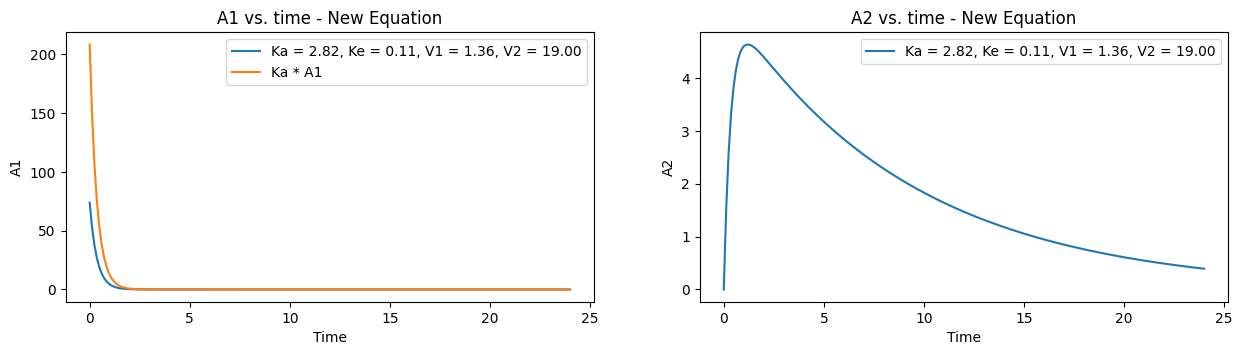

In [8]:
fig = plt.figure(figsize=(15, 3.5))
ax1 = fig.add_subplot(1,2,1)


params = task_params[0]
plt.plot(data_T, data_A1, label='Ka = %.2f, Ke = %.2f, V1 = %.2f, V2 = %.2f'%(params[0], params[1], params[2], params[3]))
plt.plot(data_T, data_y, label='Ka * A1')

plt.title("A1 vs. time - New Equation"); plt.legend();
plt.xlabel("Time"); plt.ylabel("A1");
ax1 = fig.add_subplot(1,2,2)


params = task_params[0]
plt.plot(data_T, data_A2, label='Ka = %.2f, Ke = %.2f, V1 = %.2f, V2 = %.2f'%(params[0], params[1], params[2], params[3]))
# plt.plot(data_T, data_y, label='Ke * A2')

    # plt.plot(data_T, data_A2_csv[0], label='CSV data')
plt.title("A2 vs. time - New Equation"); plt.legend();
plt.xlabel("Time"); plt.ylabel("A2");

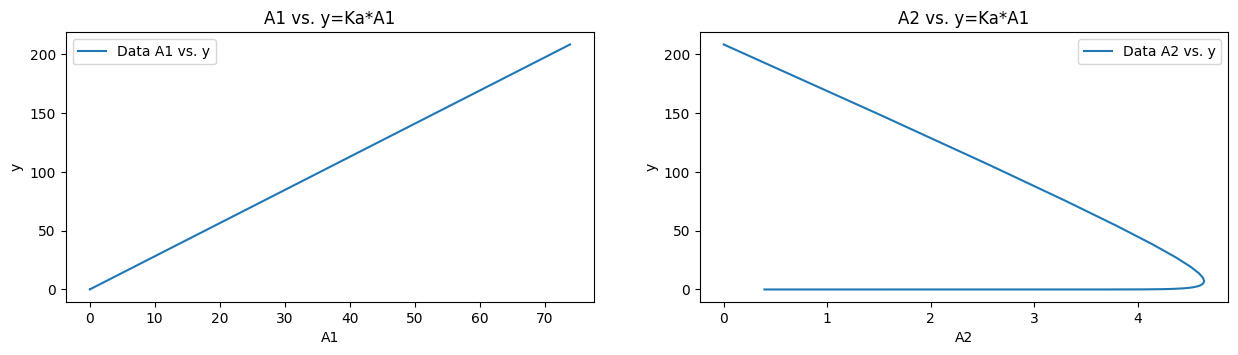

In [9]:
plt.close() #close previous plot

#Plotting A2 vs. Y
fig = plt.figure(figsize=(15, 3.5))
ax1 = fig.add_subplot(1, 2, 1)


plt.plot(data_A1, data_y, label='Data A1 vs. y')
# plt.plot(data_T, data_A1_csv[0], label='CSV data')

plt.title("A1 vs. y=Ka*A1"); plt.legend();
plt.xlabel("A1"); plt.ylabel("y");
ax2 = fig.add_subplot(1,2,2)

plt.plot(data_A2, data_y, label='Data A2 vs. y')

    # plt.plot(data_T, data_A2_csv[0], label='CSV data')
plt.title("A2 vs. y=Ka*A1"); plt.legend();
plt.xlabel("A2"); plt.ylabel("y");


## AI Feynman

In [ ]:
# Mounting colab notebook to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*Installing AI-Feynman and relevant packages*

In [ ]:
# Checking OS version, fortran compiler version, and granting relevant permissions (github only)
!sudo apt-get install csh
!lsb_release -a
!gfortran --version
!chmod +777 '/content/drive/My Drive/Symbolic-Regressor/Feynman Local/'*

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
csh is already the newest version (20110502-7).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy
GNU Fortran (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# Installing AI Feynman 2.0, c shell, and relevant packages
## https://ai-feynman.readthedocs.io/en/latest/
!pip install aifeynman --no-deps
!pip install sortedcontainers scikit-learn torch seaborn torchvision openpyxl

In [ ]:
# Importing relevant modules
import os
import random
import numpy as np
# import matplotlib as plt
import pandas as pd
import aifeynman
from aifeynman import S_brute_force, S_run_aifeynman

#Configuring plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

*Verifying working directory*

In [ ]:
input_path = '/content/drive/My Drive/Symbolic-Regressor/Feynman Local/'
os.chdir(input_path)
!pwd

/content/drive/My Drive/Symbolic-Regressor/Feynman Local


*Perfect data - generation, plotting, brute force test, symbolic regression*

(201, 3)
                0         1             2
0    7.386409e+01  0.000000  2.083706e+02
1    5.265214e+01  1.509122  1.485317e+02
2    3.753173e+01  2.565072  1.058770e+02
3    2.675354e+01  3.298249  7.547174e+01
4    1.907058e+01  3.801602  5.379810e+01
..            ...       ...           ...
196  1.772178e-11  0.414256  4.999314e-11
197  8.033132e-12  0.408824  2.266147e-11
198  7.997448e-12  0.403463  2.256080e-11
199  7.916035e-12  0.398172  2.233113e-11
200  6.091490e-12  0.392950  1.718409e-11

[201 rows x 3 columns] (201, 3)
                0         1             2
0    7.386409e+01  0.000000  2.083706e+02
1    5.265214e+01  1.509122  1.485317e+02
2    3.753173e+01  2.565072  1.058770e+02
3    2.675354e+01  3.298249  7.547174e+01
4    1.907058e+01  3.801602  5.379810e+01
..            ...       ...           ...
196  1.772178e-11  0.414256  4.999314e-11
197  8.033132e-12  0.408824  2.266147e-11
198  7.997448e-12  0.403463  2.256080e-11
199  7.916035e-12  0.398172  2.233

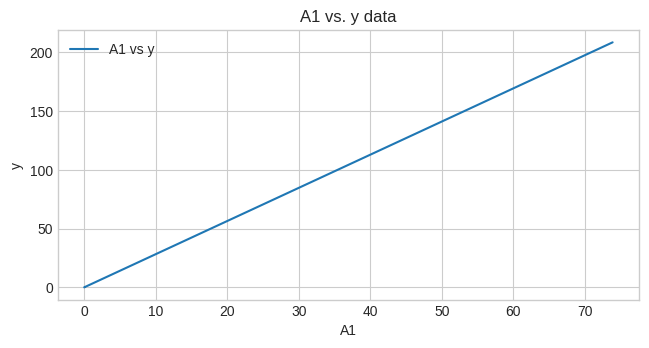

In [ ]:
data = np.stack([data_A1, data_A2, data_y]).transpose()
data = data[0]
print(data.shape)

# Saving data as a .txt file in working directory for use by symbolic regression function
np.save(input_path + 'feynman_data_KaA1.npy',data)
np.savetxt(input_path + 'feynman_data_KaA1.txt',data,delimiter=' ')
# Printing out generated data with Pandas and plotting it with matplotlib
df=pd.read_csv(input_path + 'feynman_data_KaA1.txt',sep=" ",header=None)


#plot df
fig = plt.figure(figsize=(7.5, 3.5))

plt.plot(df[0], df[2], label='A1 vs y')

plt.title("A1 vs. y data"); plt.legend();
plt.xlabel("A1"); plt.ylabel("y");
print(df, df.shape)


print(df)
#Running brute force test on perfect data
!pwd
S_brute_force.brute_force(input_path,"feynman_data_KaA1.txt",30,"14ops.txt") #may be difficult with KeA2?


In [ ]:
degrees = [1]
epochs = [10]
for degree in degrees: #50
    for num_epochs in epochs:
        print("Epochs:", num_epochs, "Degree", degree)
        # Printing out a few lines of data (purely for reference)
        !head -n 1 '/content/drive/My Drive/Symbolic-Regressor/Feynman Local/feynman_data_KaA1.txt'
        # Running symbolic regression function on generated dataset
        S_run_aifeynman.run_aifeynman(input_path,"feynman_data_KaA1.txt",30,"14ops.txt", polyfit_deg=degrees, NN_epochs=epochs)

Epochs: 10 Degree 1
7.386409050837499990e+01 0.000000000000000000e+00 2.083705993241258909e+02
Checking for brute force + 

Trying to solve mysteries with brute force...
Trying to solve /content/drive/My Drive/Symbolic-Regressor/Feynman Local/feynman_data_KaA1.txt_train
Checking for brute force * 

Trying to solve mysteries with brute force...
Trying to solve /content/drive/My Drive/Symbolic-Regressor/Feynman Local/feynman_data_KaA1.txt_train
Checking polyfit 

Pareto frontier in the current branch:

Complexity #  MDL Loss #  Expression
14.0 4.0 0.999999999998+((x0*(pi-(pi)**(-1)))-1)

Checking for brute force + 

Trying to solve mysteries with brute force...
Trying to solve results/mystery_world_squared/feynman_data_KaA1.txt_train
Checking for brute force * 

Trying to solve mysteries with brute force...
Trying to solve results/mystery_world_squared/feynman_data_KaA1.txt_train
Checking polyfit 

Pareto frontier in the current branch:

Complexity #  MDL Loss #  Expression
8.34 7.89 sqr

In [ ]:
# Viewing processed data - if file not found, try running again
!ls -1 '/content/drive/My Drive/Symbolic-Regressor/Feynman Local/results'
!cat '/content/drive/My Drive/Symbolic-Regressor/Feynman Local/results/solution_feynman_data_KaA1.txt'

gen_sym
gradients_gen_sym_noisydata.txt_train
gradients_gen_sym_noisydata.txt_train-translated_plus
mystery_world_acos
mystery_world_asin
mystery_world_atan
mystery_world_cos
mystery_world_exp
mystery_world_inverse
mystery_world_log
mystery_world_sin
mystery_world_sqrt
mystery_world_squared
mystery_world_tan
NN_trained_models
separable_add
solution_before_snap_feynman_data_KaA1-KeA2.txt.txt
solution_before_snap_feynman_data_KaA1.txt.txt
solution_before_snap_feynman_data_KeA2.txt.txt
solution_before_snap_feynman_data.txt.txt
solution_before_snap_noisydata.txt.txt
solution_feynman_data-finetuning.txt
solution_feynman_data_KaA1-KeA2.txt
solution_feynman_data_KaA1.txt
solution_feynman_data_KeA2.txt
solution_feynman_data.txt
solution_first_snap_feynman_data_KaA1-KeA2.txt.txt
solution_first_snap_feynman_data_KaA1.txt.txt
solution_first_snap_feynman_data_KeA2.txt.txt
solution_first_snap_feynman_data.txt.txt
solution_first_snap_noisydata.txt.txt
solution_noisydata.txt
translated_data_minus
tra

Plotting solution

In [18]:
def y_soln(x0, x1):
  # y = jnp.asin(0.000000000011+x0)
  y = jnp.asin(-0.999999999981+(x0+1))
  #y = jnp.asin(2.821000000000*(x0*jnp.cos(x0)))
  return y

In [19]:
print(data_A1.shape, data_A2.shape)
soln = y_soln(data_A1, data_A2)
soln.shape

(201, 1) (201, 1)


(201, 1)

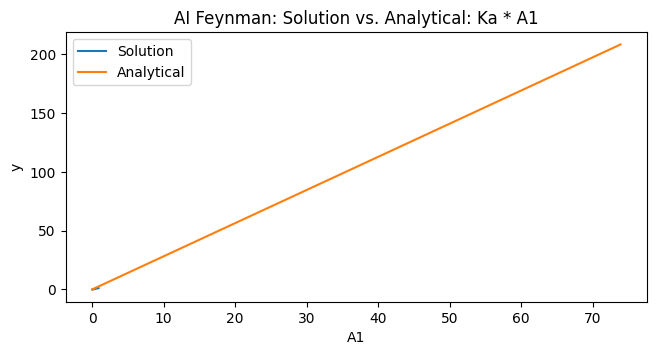

In [20]:
fig = plt.figure(figsize=(7.5, 3.5))

params = task_params[0]
plt.plot(data_A1, soln, label='Solution')
plt.plot(data_A1, data_y, label='Analytical')
# plt.plot(data_T, data_A1_csv[0], label='CSV data')

plt.title("AI Feynman: Solution vs. Analytical: Ka * A1"); plt.legend();
plt.xlabel("A1"); plt.ylabel("y");

In [21]:
#TODO: mse between SR solution and analytical solution
print(soln.shape, data_y.shape)
jnp.mean(jnp.square(soln - data_y))

(201, 1) (201, 1)


Array(nan, dtype=float64)